In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')
f = 'drive/MyDrive/BABD_projects/'
#f=''

df = pd.read_csv(f+'complaints_cleaned.csv', index_col=0)

Mounted at /content/drive


In [3]:
df.shape

(162405, 3)

In [4]:
df.head()

,product,narrative,cleaned_narrative
0,credit_card,purchase order day shipping amount receive pro...,purchase order ship amount receive product wee...
1,credit_card,forwarded message date tue subject please inve...,forward message date subject please investigat...
2,retail_banking,forwarded message cc sent friday pdt subject f...,forwarded message send friday subject final le...
3,credit_reporting,payment history missing credit report speciali...,payment history miss credit report specialize ...
4,credit_reporting,payment history missing credit report made mis...,payment history miss credit report make mistak...


In [5]:
df.isna().sum()

product              0
narrative            0
cleaned_narrative    2
dtype: int64

In [6]:
df['narrative'] = df['narrative'].astype(str)

## 2nd task

Topic modeling

In [7]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import matutils, models
from gensim.corpora import Dictionary
import scipy.sparse

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def prepare_corpus():
    cv = TfidfVectorizer(stop_words=stop_words, min_df=0.1, max_df= 0.8)
    data_cv = cv.fit_transform(df['narrative'])
    data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
    data.index = df.index
    tdm = data.transpose()
    sparse_counts = scipy.sparse.csr_matrix(tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)

    #d = corpora.Dictionary()
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())

    gensim_dict = Dictionary.from_corpus(corpus, id2word=id2word)

    return gensim_dict,corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LDA topic models
              c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate model
        model = LsiModel(corpus, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        c_v.append(coherencemodel.get_coherence())
    return model_list, c_v

In [13]:
dictionary,corpus=prepare_corpus()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


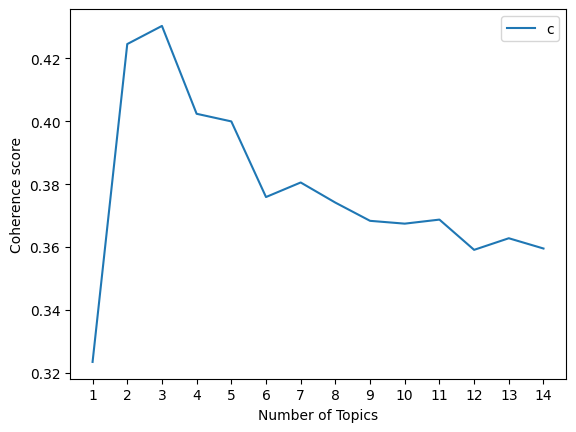

In [9]:
nltk.download('punkt')
from nltk import word_tokenize
import matplotlib.pyplot as plt

def plot_graph(doc_clean, start, stop, step):
    model_list,c_v = compute_coherence_values(dictionary, corpus, doc_clean,
                                                            stop, start, step)


    # cv
    x = range(start, stop, step)
    fig = plt.plot(x, c_v, label = 'cv')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(('cv'), loc='best')
    plt.xticks(ticks = x)
    plt.show()
    plt.close()

    return model_list

model_list = plot_graph(df['narrative'].apply(word_tokenize),1,15,1)

In [10]:
ntopic = 3
model = model_list[ntopic-1]
model.show_topics()

[(0,
  '0.420*"account" + 0.399*"credit" + 0.287*"report" + 0.177*"information" + 0.173*"payment" + 0.150*"reporting" + 0.139*"company" + 0.131*"debt" + 0.124*"time" + 0.124*"day"'),
 (1,
  '-0.443*"payment" + 0.319*"report" + 0.282*"credit" + -0.251*"loan" + -0.222*"bank" + 0.163*"identity" + -0.160*"would" + -0.160*"late" + 0.149*"item" + 0.145*"theft"'),
 (2,
  '0.454*"account" + -0.411*"item" + -0.280*"identity" + -0.247*"report" + 0.230*"debt" + -0.230*"theft" + -0.161*"remove" + 0.158*"balance" + -0.155*"payment" + 0.154*"collection"')]

In [11]:
ntopic = 5
model = model_list[ntopic-1]
model.show_topics()

[(0,
  '0.417*"account" + 0.402*"credit" + 0.290*"report" + 0.178*"information" + 0.172*"payment" + 0.150*"reporting" + 0.139*"company" + 0.129*"debt" + 0.124*"time" + 0.123*"day"'),
 (1,
  '-0.434*"payment" + 0.327*"report" + 0.295*"credit" + -0.251*"loan" + -0.230*"bank" + -0.162*"would" + -0.151*"late" + 0.150*"item" + -0.145*"told" + -0.144*"call"'),
 (2,
  '0.774*"account" + -0.211*"credit" + -0.201*"loan" + -0.198*"payment" + 0.197*"bank" + -0.173*"report" + -0.130*"debt" + -0.129*"reporting" + 0.126*"fraudulent" + -0.126*"day"'),
 (3,
  '0.609*"debt" + 0.335*"collection" + -0.276*"item" + -0.252*"report" + -0.212*"credit" + -0.204*"card" + 0.160*"reporting" + 0.145*"company" + 0.140*"agency" + -0.131*"remove"'),
 (4,
  '-0.492*"identity" + -0.460*"theft" + 0.321*"day" + 0.222*"dispute" + 0.198*"account" + 0.174*"inaccurate" + 0.170*"letter" + 0.156*"response" + 0.150*"sent" + 0.143*"reporting"')]

In [33]:
list_guess = [
    'credit',
    'payment',
    'loans and credits',
    'debt collection',
    'identity theft'
]

In [14]:
corpus_transformed = model[corpus]

import numpy as np

from pandas.core.common import not_none
topic_prediction=[]
for j in list(corpus_transformed):
    if len(j) > 0:
        main_topic=j[0][0]
        weigth=np.abs(j[0][1])
        for t,w in j:
            if np.abs(w) > weigth :
                main_topic=t
                weigth=np.abs(w)
    topic_prediction.append(main_topic)

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(df['product']))

print(le.classes_)

products=le.transform(list(df['product']))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']


In [27]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(products,topic_prediction,normalize='pred') #normalize by columns
print(cm)

[[0.10094729 0.13916842 0.0425815  0.01661912 0.0204918 ]
 [0.63717135 0.12125401 0.37641384 0.31501922 0.83180328]
 [0.12429115 0.07856906 0.05904857 0.64529332 0.12065574]
 [0.07048267 0.54528364 0.02611444 0.01661912 0.0142623 ]
 [0.06710755 0.11572487 0.49584165 0.00644921 0.01278689]]


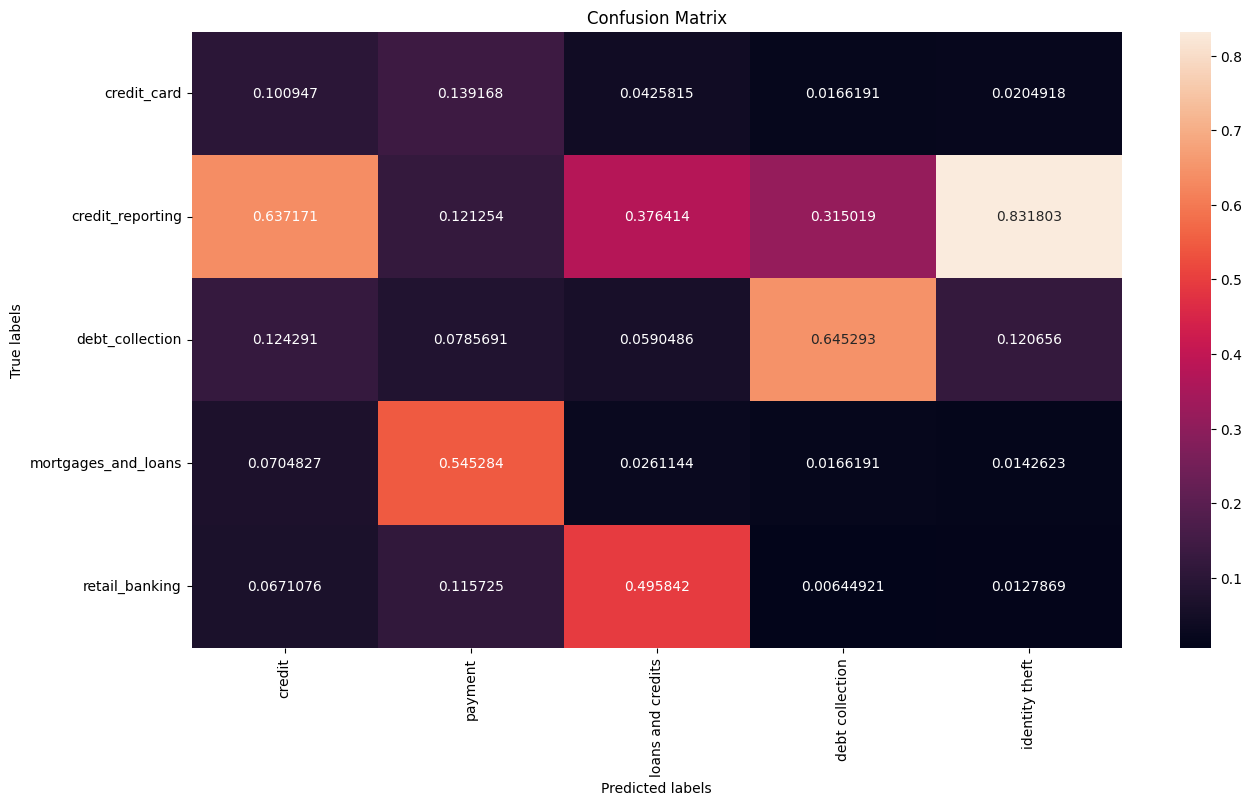

In [34]:
import seaborn as sns
plt.figure(figsize = (15,8))

ax=sns.heatmap(cm, annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.yaxis.set_ticklabels(le.classes_)
ax.tick_params(axis='y', rotation=0)
ax.xaxis.set_ticklabels(list_guess)
ax.tick_params(axis='x', rotation=90)
plt.show()
plt.close()
#plt.set_xticklabels(ax.get_xticklabels(),rotation = 30)